In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# XOR

We'll try a classification problem at first.

In [2]:
class SimpleF(nn.Module):
    def __init__(self, input_size=1, n_states=2):
        super().__init__()
        
        self.n_states = n_states

        self.A = nn.Linear(n_states,n_states)
        self.B = nn.Linear(input_size,n_states)

        # decreasing initial weights to increase stability
        self.A.weight = nn.Parameter(0.1 * self.A.weight)
        self.B.weight = nn.Parameter(0.1 * self.B.weight)

    def forward(self, z, x):
        return torch.sigmoid(self.A(z) + self.B(x))

So, omitting the biases, our function is simply $f_\theta(z,x) = \sigma(Az + Bx)$.

## Forward

Let's keep it simple for now.

In [22]:
def forward_iteration(f, x0, max_iter=50, tol=1e-2):
    f0 = f(x0)
    res = []
    for k in range(max_iter):
        x = f0
        f0 = f(x)
        res.append((f0 - x).norm().item() / (1e-5 + f0.norm().item()))
        if (res[-1] < tol):
            break
    return f0, res

f = SimpleF(n_states=3, input_size=2).float()
z0 = torch.Tensor([[0.,0.,0.]])
z, res = forward_iteration(lambda z: f(z,torch.Tensor([[1.,0.]])),z0)
z, res

(tensor([[0.7284, 0.4794, 0.2835]], grad_fn=<SigmoidBackward0>),
 [0.009819126260899919])

In [121]:
def anderson(f, x0, m=3, lam=1e-4, max_iter=50, tol=1e-2, beta = 1.0):
    """ Anderson acceleration for fixed point iteration. """
    bsz, d = x0.shape
    X = torch.zeros(bsz, m, d, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, d, dtype=x0.dtype, device=x0.device)
    X[:,0], F[:,0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:,1], F[:,1] = F[:,0], f(F[:,0].view_as(x0)).view(bsz, -1)

    H = torch.zeros(bsz, m+1, m+1, dtype=x0.dtype, device=x0.device)
    H[:,0,1:] = H[:,1:,0] = 1
    y = torch.zeros(bsz, m+1, 1, dtype=x0.dtype, device=x0.device)
    y[:,0] = 1

    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:,:n]-X[:,:n]
        H[:,1:n+1,1:n+1] = torch.bmm(G,G.transpose(1,2)) + lam*torch.eye(n, dtype=x0.dtype,device=x0.device)[None]
        alpha = torch.solve(y[:,:n+1], H[:,:n+1,:n+1])[0][:, 1:n+1, 0]   # (bsz x n)
        
        X[:,k%m] = beta * (alpha[:,None] @ F[:,:n])[:,0] + (1-beta)*(alpha[:,None] @ X[:,:n])[:,0]
        F[:,k%m] = f(X[:,k%m].view_as(x0)).view(bsz, -1)
        res.append((F[:,k%m] - X[:,k%m]).norm().item()/(1e-5 + F[:,k%m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:,k%m].view_as(x0), res

f = SimpleF(n_states=3, input_size=2).float()
z0 = torch.Tensor([[0.,0.,0.]])
z, res = anderson(lambda z: f(z,torch.Tensor([[1.,0.]])),z0)
z, res

/tmp/ipykernel_33268/1562778880.py:19: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  alpha = torch.solve(y[:,:n+1], H[:,:n+1,:n+1])[0][:, 1:n+1, 0]   # (bsz x n)


(tensor([[0.6340, 0.3872, 0.4614]], grad_fn=<ViewBackward0>),
 [0.0003060863502322672])

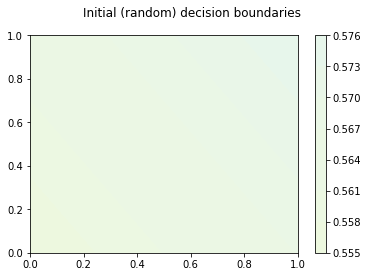

In [26]:
f = SimpleF(n_states=3, input_size=2).float()

xx, yy = np.meshgrid(np.linspace(0,1, 100), np.linspace(0, 1, 100))

x = np.c_[xx.ravel(),yy.ravel()]
with torch.no_grad():
    z, _ = forward_iteration(lambda z: f(z,torch.Tensor(x)),z0, tol=1e-4)
y_pred = z[:,-1].detach().numpy().reshape(xx.shape)

cs = plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, vmin=0, vmax=1)
plt.colorbar(cs)
plt.suptitle('Initial (random) decision boundaries')
plt.show()

## Handcrafted weights

$z$'s last element will be the output.

In [27]:
# XOR weights, based on a FC network
f = SimpleF(n_states=3, input_size=2).float()
f.A.weight = nn.Parameter(torch.Tensor([
    [1., 0., 0.],
    [0., 1., 0.],
    [20., 20., 0.],
]))
f.A.bias = nn.Parameter(torch.Tensor([0., 0., -30.]))
f.B.weight = nn.Parameter(torch.Tensor([
    [20., 20.],
    [-20., -20.],
    [0., 0.],
]))
f.B.bias = nn.Parameter(torch.Tensor([-10., 30., 0.]))

z0 = torch.Tensor([[0.,0.,0.]])
x = torch.Tensor([[0.,0.]])
f_x = lambda z: f(z,x)
f_x(f_x(f_x(f_x(z0))))

tensor([[4.5400e-05, 1.0000e+00, 4.5439e-05]], grad_fn=<SigmoidBackward0>)

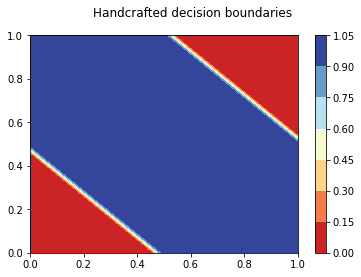

In [28]:
xx, yy = np.meshgrid(np.linspace(0,1, 100), np.linspace(0, 1, 100))

x = np.c_[xx.ravel(),yy.ravel()]
with torch.no_grad():
    z, _ = forward_iteration(lambda z: f(z,torch.Tensor(x)),z0)
y_pred = z[:,-1].detach().numpy().reshape(xx.shape)

cs = plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, vmin=0, vmax=1)
plt.colorbar(cs)
plt.suptitle('Handcrafted decision boundaries')
plt.show()

# Backward

In [122]:
from torch.autograd import gradcheck

class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs

    def forward(self, x):
        # compute forward pass
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z : self.f(z, x), torch.zeros(x.shape[0],f.n_states), **self.kwargs)

        # re-engage autograd, like a forward pass with a really good initial guess
        z = self.f(z,x)

        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0, x)
        def backward_hook(y):
            g, self.backward_res = self.solver(lambda g : autograd.grad(f0, z0, g, retain_graph=True)[0] + y,
                                               y, **self.kwargs)
            return g

        z.register_hook(backward_hook)
        return z

f = SimpleF(n_states=3, input_size=2).float()
x = torch.Tensor([
    [0.,0.],
    [0.,1.],
    [1.,0.],
    [1.,1.],
])
# x = torch.Tensor([
#     [.5, .5],
# ])
deq = DEQFixedPoint(f, anderson, tol=1e-8, max_iter=500).float()
gradcheck(deq, x.requires_grad_(), eps=1e-4, atol=1e-3, check_undefined_grad=False)

/home/bruno/miniconda3/envs/deq-vdp/lib/python3.10/site-packages/torch/autograd/gradcheck.py:647: UserWarning: Input #0 requires gradient and is not a double precision floating point or complex. This check will likely fail if all the inputs are not of double precision floating point or complex. 
  warnings.warn(


True

# Training

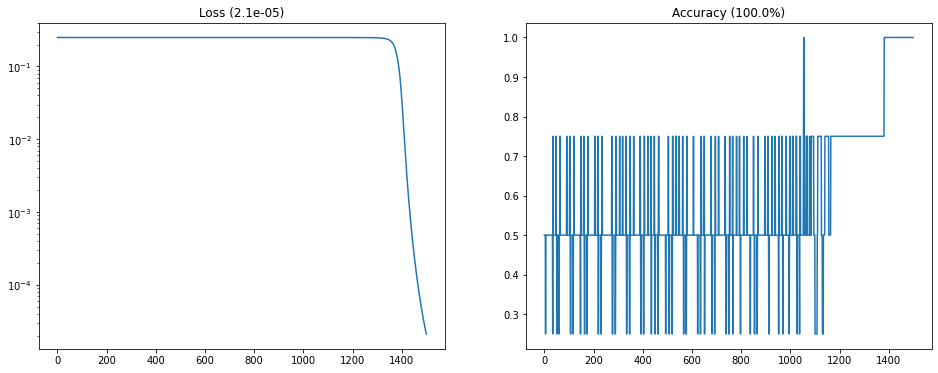

CPU times: user 4.77 s, sys: 123 ms, total: 4.89 s
Wall time: 2.77 s


In [126]:
%%time
f = SimpleF(n_states=6, input_size=2).float()
model = DEQFixedPoint(f, forward_iteration, tol=1e-6, max_iter=500)

loss_f = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.99)

accs = list()
losses = list()
y_preds = list()

X = torch.Tensor([
    [0.,0.],
    [0.,1.],
    [1.,0.],
    [1.,1.],
])
y = torch.logical_xor(X[:,0], X[:,1]).float().unsqueeze(-1)

ys_surface = list()
for e in range(1500):
    model.train()

    y_pred = model(X)[:,-1:]

    loss = loss_f(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_preds.append(y_pred.detach().numpy())
    accs.append(
        (y_pred.round() == y.round()).sum() / y.shape[0]
    )
    losses.append(loss.item())
    
    if e % 10 == 0:
        model.eval()
        xx, yy = np.meshgrid(np.linspace(0,1, 100), np.linspace(0, 1, 100))

        x = np.c_[xx.ravel(),yy.ravel()]
        z0 = torch.zeros(x.shape[0],f.n_states)
        with torch.no_grad():
            z, _ = forward_iteration(lambda z: f(z,torch.Tensor(x)),z0)
        ys_surface.append(z[:,-1].detach().numpy().reshape(xx.shape))

fig, axs = plt.subplots(1,2)
fig.set_size_inches(16,6)

axs[0].semilogy(losses)
axs[0].set_title(f"Loss ({losses[-1]:.1e})")

axs[1].plot(accs)
axs[1].set_title(f"Accuracy ({100*accs[-1]:.1f}%)")

plt.show()

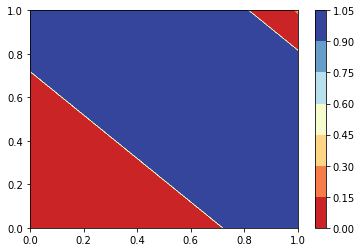

In [127]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
cs = ax.contourf(xx, yy, ys_surface[-1], cmap=plt.cm.RdYlBu, vmin=0, vmax=1)
fig.colorbar(cs)

def animate(i):
    ax.contourf(xx, yy, ys_surface[i], cmap=plt.cm.RdYlBu, vmin=0, vmax=1)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(ys_surface))

from IPython.display import HTML
HTML(ani.to_jshtml())

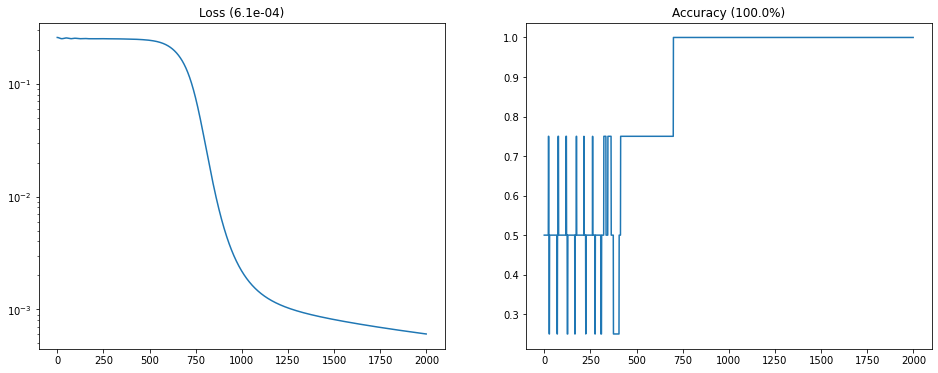

CPU times: user 3.26 s, sys: 96.1 ms, total: 3.36 s
Wall time: 1.94 s


In [141]:
%%time

model = nn.Sequential(
    nn.Linear(2,3),
    nn.Sigmoid(),
    nn.Linear(3,1),
    nn.Sigmoid(),
)

loss_f = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.99)

accs = list()
losses = list()
y_preds = list()
ys_surface = list()

X = torch.Tensor([
    [0.,0.],
    [0.,1.],
    [1.,0.],
    [1.,1.],
])
y = torch.logical_xor(X[:,0], X[:,1]).float().unsqueeze(-1)

for e in range(2000):
    model.train()

    y_pred = model(X)[:,-1:]

    loss = loss_f(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_preds.append(y_pred.detach().numpy())
    accs.append(
        (y_pred.round() == y.round()).sum() / y.shape[0]
    )
    losses.append(loss.item())

    if e % 10 == 0:
        model.eval()
        xx, yy = np.meshgrid(np.linspace(0,1, 100), np.linspace(0, 1, 100))

        x = np.c_[xx.ravel(),yy.ravel()]
        z0 = torch.zeros(x.shape[0],f.n_states)
        with torch.no_grad():
            y_pred = model(torch.Tensor(x))[:,-1:]
        ys_surface.append(y_pred.detach().numpy().reshape(xx.shape))

fig, axs = plt.subplots(1,2)
fig.set_size_inches(16,6)

axs[0].semilogy(losses)
axs[0].set_title(f"Loss ({losses[-1]:.1e})")

axs[1].plot(accs)
axs[1].set_title(f"Accuracy ({100*accs[-1]:.1f}%)")

plt.show()

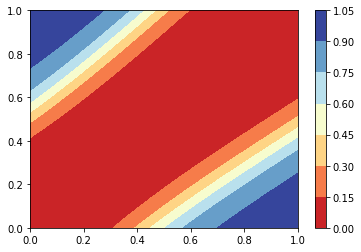

In [142]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
cs = ax.contourf(xx, yy, ys_surface[-1], cmap=plt.cm.RdYlBu, vmin=0, vmax=1)
fig.colorbar(cs)

def animate(i):
    ax.contourf(xx, yy, ys_surface[i], cmap=plt.cm.RdYlBu, vmin=0, vmax=1)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(ys_surface))

from IPython.display import HTML
HTML(ani.to_jshtml())

## Solver performance comparison

Forward iteration vs. Anderson.

In [128]:
%%timeit
f = SimpleF(n_states=6, input_size=2).float()
model = DEQFixedPoint(f, forward_iteration, tol=1e-6, max_iter=500)

loss_f = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.99)

accs = list()
losses = list()
y_preds = list()

X = torch.Tensor([
    [0.,0.],
    [0.,1.],
    [1.,0.],
    [1.,1.],
])
y = torch.logical_xor(X[:,0], X[:,1]).float().unsqueeze(-1)

ys_surface = list()
for e in range(1500):
    model.train()

    y_pred = model(X)[:,-1:]

    loss = loss_f(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

The slowest run took 28.60 times longer than the fastest. This could mean that an intermediate result is being cached.
15.4 s ± 17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [129]:
%%timeit
f = SimpleF(n_states=6, input_size=2).float()
model = DEQFixedPoint(f, anderson, tol=1e-6, max_iter=500)

loss_f = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.99)

accs = list()
losses = list()
y_preds = list()

X = torch.Tensor([
    [0.,0.],
    [0.,1.],
    [1.,0.],
    [1.,1.],
])
y = torch.logical_xor(X[:,0], X[:,1]).float().unsqueeze(-1)

ys_surface = list()
for e in range(1500):
    model.train()

    y_pred = model(X)[:,-1:]

    loss = loss_f(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

12.8 s ± 3.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
